In [223]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# ========= SETTINGS =========
CAND_FILE = "../src_csv/xau_m5_candidates_ea3.csv"
M1_FILE   = "../src_csv/not_used/m1_2025-20260220.csv"
# M1_FILE   = "../src_csv/m1_master.csv"

POINT = 0.01
USD_PER_POINT = 0.01
START_BALANCE = 100.0

SL_PTS = 500 
TP_PTS = 1500
MAX_MINUTES = 60
EARLY_MINUTES = 60

SL_TO_STOP = 1          # 🔴 stop after N SL
STOP_MODE = "session"   # "session" or "day"

SPREAD_PTS = 8
SPREAD = SPREAD_PTS * POINT

START_ALL = "2026-01-01 00:00"
END_ALL   = "2026-02-20 23:59"
# =================================

In [224]:
# ===== LOAD =====
cand = pd.read_csv(CAND_FILE)
cand.columns = cand.columns.str.strip()
cand["time"] = pd.to_datetime(cand["time"])
cand = cand.sort_values("time")

m1 = pd.read_csv(M1_FILE)
m1.columns = m1.columns.str.strip()
m1["time"] = pd.to_datetime(m1["time"])
m1 = m1.sort_values("time").set_index("time")

cand = cand[
    (cand["time"] >= START_ALL) &
    (cand["time"] <= END_ALL)
].copy()

In [225]:
# ===== SESSION =====
def get_session(h):
    if 0 <= h < 8: return "Asia"
    elif 8 <= h < 16: return "Europe"
    else: return "America"

cand["hour"] = cand["time"].dt.hour
cand["session"] = cand["hour"].apply(get_session)
cand["date"] = cand["time"].dt.date


# ===== SIM =====
def simulate_one(t0, side):

    t_entry = t0 + pd.Timedelta(minutes=4)
    if t_entry not in m1.index:
        return ("NO_ENTRY", np.nan)

    entry_close = float(m1.loc[t_entry]["close"])

    if side == "BUY":
        entry = entry_close + SPREAD/2
        sl = entry - SL_PTS*POINT
        tp = entry + TP_PTS*POINT
    else:
        entry = entry_close - SPREAD/2
        sl = entry + SL_PTS*POINT
        tp = entry - TP_PTS*POINT

    future = m1.loc[t_entry:].iloc[1:MAX_MINUTES+1]

    for i, (_, row) in enumerate(future.iterrows(), start=1):

        close_price = float(row["close"])
        bid = close_price - SPREAD/2
        ask = close_price + SPREAD/2

        if side == "BUY":
            if bid <= sl: return ("SL", -SL_PTS)
            if bid >= tp: return ("TP", TP_PTS)
        else:
            if ask >= sl: return ("SL", -SL_PTS)
            if ask <= tp: return ("TP", TP_PTS)

        if EARLY_MINUTES and i >= EARLY_MINUTES:
            profit = (bid-entry)/POINT if side=="BUY" else (entry-ask)/POINT
            if profit > 0:
                return ("EARLY", profit)

        if i >= MAX_MINUTES:
            profit = (bid-entry)/POINT if side=="BUY" else (entry-ask)/POINT
            return ("TIME", profit)

    return ("NO_DATA", np.nan)

In [226]:
# ===== BACKTEST ENGINE =====
def run_backtest(cand):

    results = []
    sl_counter = {}
    blocked = set()

    for row in cand.itertuples():

        if STOP_MODE == "session":
            key = (row.date, row.session)
        else:
            key = row.date

        if key in blocked:
            results.append(("BLOCKED", np.nan, 0))
            continue

        reason, pts = simulate_one(row.time, row.side)

        if np.isnan(pts):
            results.append((reason, np.nan, 0))
            continue

        pnl = pts * USD_PER_POINT
        results.append((reason, pts, pnl))

        if reason == "SL":
            sl_counter[key] = sl_counter.get(key, 0) + 1
        else:
            sl_counter[key] = 0

        if sl_counter[key] >= SL_TO_STOP:
            blocked.add(key)

    return results

In [227]:
# ===== RUN =====
results = run_backtest(cand)

cand["exit_reason"] = [r[0] for r in results]
cand["points"]      = [r[1] for r in results]
cand["pnl_usd"]     = [r[2] for r in results]
cand["win"]         = cand["pnl_usd"] > 0

cand["balance"] = START_BALANCE + cand["pnl_usd"].cumsum()

master = cand.dropna(subset=["points"]).copy()

In [228]:
# =====================================================
# =============== MASTER FILTER TABLE =================
# =====================================================

master = cand.dropna(subset=["points"]).copy()

In [229]:
# ================= DASHBOARD =================

def show_dashboard(df):
    
    print("\n====== FINAL RESULTS ======")
    print(f'{df["time"].min()} - {df["time"].max()}')
    print("===========================")
    print("Start balance:", START_BALANCE)
    print("End balance:", START_BALANCE + df["pnl_usd"].sum())
    print("Total PnL:", df["pnl_usd"].sum())
    print("Total trade:", len(df))
    print("Total win:", (df["points"] > 0).sum())
    print("Total loss:", (df["points"] < 0).sum())
    print()
    print("Avg. PnL:", df["pnl_usd"].mean())
    print("Winrate:", (df["points"] > 0).mean())

    equity = START_BALANCE + df["pnl_usd"].cumsum()
    drawdown = equity.cummax() - equity
    print("Max Drawdown:", drawdown.max())

    # Equity
    plt.figure()
    plt.plot(equity.values)
    plt.title("Equity Curve")
    plt.show()

    # Session PnL
    pivot = df.groupby(["session","side"])["points"].sum().unstack()
    pivot.plot(kind="bar")
    plt.title("Net Points by Session & Side")
    plt.show()

    # Daily
    daily = df.groupby("date")["pnl_usd"].sum()
    plt.figure()
    plt.bar(daily.index.astype(str), daily.values)
    plt.xticks(rotation=90)
    plt.title("Daily PnL")
    plt.show()


====== FINAL RESULTS ======
2026-01-02 03:15:00 - 2026-02-20 17:15:00
Start balance: 100.0
End balance: 363.5300000000043
Total PnL: 263.5300000000043
Total trade: 161
Total win: 74
Total loss: 87

Avg. PnL: 1.6368322981366725
Winrate: 0.45962732919254656
Max Drawdown: 53.4399999999996


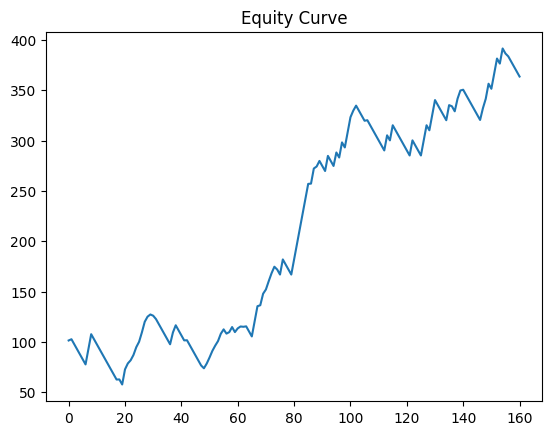

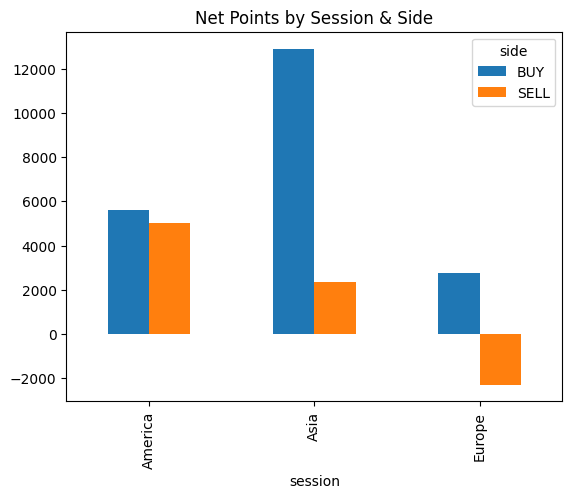

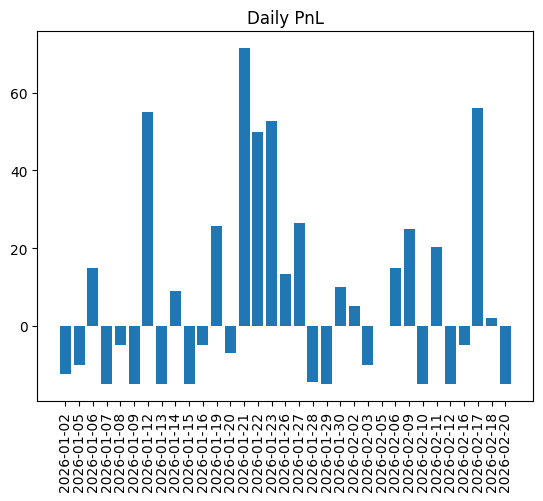

In [230]:
# ===== USE FILTER HERE =====
filtered = master.copy()

# Example filters:
# filtered = master[master["session"]=="America"]
# filtered = master[master["side"]=="BUY"]
# filtered = master[(master["session"]=="America") & (master["side"]=="BUY")]

show_dashboard(filtered)

In [231]:
filtered

,time,side,ema2,close2,high1,low1,body_pts,atr,r1,r2,...,r9,r10,hour,session,date,exit_reason,points,pnl_usd,win,balance
0,2026-01-02 03:15:00,SELL,4345.212230,4346.61,4349.72,4345.02,34.0,4.621429,255.0,30.0,...,15.0,116.0,3,Asia,2026-01-02,EARLY,149.0,1.49,True,101.49
1,2026-01-02 03:25:00,SELL,4345.659807,4346.34,4349.52,4344.61,282.0,4.491429,283.0,-282.0,...,222.0,108.0,3,Asia,2026-01-02,EARLY,123.0,1.23,True,102.72
2,2026-01-02 03:40:00,SELL,4346.587969,4348.94,4349.69,4345.72,68.0,4.260000,-228.0,-69.0,...,-599.0,174.0,3,Asia,2026-01-02,SL,-500.0,-5.00,False,97.72
8,2026-01-02 08:05:00,SELL,4376.740037,4377.48,4377.55,4373.97,326.0,2.887143,-259.0,-326.0,...,19.0,129.0,8,Europe,2026-01-02,SL,-500.0,-5.00,False,92.72
13,2026-01-02 21:05:00,SELL,4319.545002,4319.76,4321.90,4317.99,455.0,4.592143,117.0,455.0,...,-72.0,87.0,21,America,2026-01-02,SL,-500.0,-5.00,False,87.72
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
832,2026-02-18 08:00:00,SELL,4932.568752,4933.40,4934.26,4928.75,349.0,3.867857,-122.0,-339.0,...,340.0,11.0,8,Europe,2026-02-18,TIME,-286.0,-2.86,False,383.53
833,2026-02-18 08:25:00,SELL,4931.226078,4931.44,4932.61,4930.22,379.0,3.919286,-89.0,380.0,...,98.0,-414.0,8,Europe,2026-02-18,SL,-500.0,-5.00,False,378.53
842,2026-02-20 03:30:00,BUY,5000.907605,4999.57,5003.80,4997.20,305.0,5.611429,15.0,-305.0,...,472.0,211.0,3,Asia,2026-02-20,SL,-500.0,-5.00,False,373.53
851,2026-02-20 09:35:00,BUY,5017.357221,5014.42,5017.89,5013.98,93.0,5.042857,347.0,-93.0,...,-506.0,-399.0,9,Europe,2026-02-20,SL,-500.0,-5.00,False,368.53
